## Loading the .mat files

We load the data associated with subjects with **tricuspid aortic valve (TAV)**, **bicuspid aortic valve (BAV)**, and **CT to MRI** data into a dictionary.

In [1]:
import numpy as np
import os
import h5py

# specify the folder containing the .mat files
fldr = r'C:\Users\mem1342\OneDrive - Northwestern University\gan ct to mri transformation\MRI2MRIdataset'

keywords = ['tav', 'bav', 'ct2mri']
file_paths = [os.path.join(fldr, f) for f in os.listdir(fldr) if any(key in f for key in keywords)]
if file_paths:
    for file in file_paths:
        print(f"Found file: {os.path.basename(file)}")
else:
    print("No files found.")
    
# Initialize the data dictionary with empty lists for the 'anatomy' and 'flow' key 
# of each of the three keys 'tav', 'bav', and 'ct2mri'
data = {'tav': {'anatomy': [], 'flow': []}, 
        'bav': {'anatomy': [], 'flow': []}, 
        'ct2mri': {'anatomy': [], 'flow': []}}

# Iterate through the file paths
for file in file_paths:
    # Iterate through the keys in the data dictionary
    for key in data.keys():
        # Check if the key is present in the current file path
        if key in file:
            # Open the file using h5py
            with h5py.File(file,'r') as f:
                # Get the anatomy and flow datasets
                anatomy_dataset = f['data']['input']
                flow_dataset = f['data']['flow']
                # Iterate through each element in the anatomy dataset
                for ii in range(len(anatomy_dataset)):
                    # Get the anatomy data and transpose it to the desired shape
                    anatomy_data = f.get(anatomy_dataset[ii][0])[()]
                    data[key]['anatomy'].append(np.transpose(anatomy_data, (2, 1, 0)))
                    # Get the flow data and transpose it to the desired shape
                    flow_data = f.get(flow_dataset[ii][0])[()]
                    dims = flow_data.ndim
                    if dims>3:
                        # L2-norm of the flow data
                        flow_data = np.linalg.norm(flow_data,ord=2,axis=0)
                    data[key]['flow'].append(np.transpose(flow_data, (2, 1, 0)))
            # Iterate through the data and check that the anatomy and flow data have the same shape
            for ii,(anatomy,flow) in enumerate(zip(data[key]['anatomy'], data[key]['flow'])):
                assert anatomy.shape == flow.shape, f"Error: data at {ii} don't have the same shape"
            print(f"{os.path.basename(file)} was loaded successfuly!")

Found file: bav_data.mat
Found file: ct2mri_data.mat
Found file: tav_data.mat
bav_data.mat was loaded successfuly!
ct2mri_data.mat was loaded successfuly!
tav_data.mat was loaded successfuly!


## Post-processing

The post processing has two steps: 

1. Removing the zero planes.
2. Padding to a common size (192, 192, 64)

In [2]:
max_dim = (192, 192, 64)

def zero_pad(array):
    """
    This function takes an input 3D array and pads it with zeros to match the size of max_dim.
    The padding is added evenly on both sides in each dimension.
    """
    pad_to = [x - y for x, y in zip(max_dim, array.shape)]
    array = np.pad(array, [(x // 2, np.max(y - x // 2 - z, 0)) for x, y, z in zip(pad_to, max_dim, array.shape)], 
                   mode='constant', constant_values=0)
    return array

for key in data.keys():
    """
    This loop iterates through the keys in the data dictionary.
    For each key, it accesses the 'anatomy' and 'flow' data, removes any zero values,
    and then pads the resulting data with zeros to match the size of max_dim.
    """
    anatomy_data = data[key]['anatomy']
    data[key]['anatomy'] = [zero_pad(anatomy[np.unique(np.where(anatomy != 0)[0]), :, :]
                                     [:, np.unique(np.where(anatomy != 0)[1]), :]
                                     [:, :, np.unique(np.where(anatomy != 0)[2])]) for anatomy in anatomy_data]
    flow_data = data[key]['flow']
    data[key]['flow'] = [zero_pad(flow[np.unique(np.where(flow != 0)[0]), :, :]
                                  [:, np.unique(np.where(flow != 0)[1]), :]
                                  [:, :, np.unique(np.where(flow != 0)[2])]) for flow in flow_data]


## Visualize the anatomy and flow data for differernt subjects

<IPython.core.display.Javascript object>


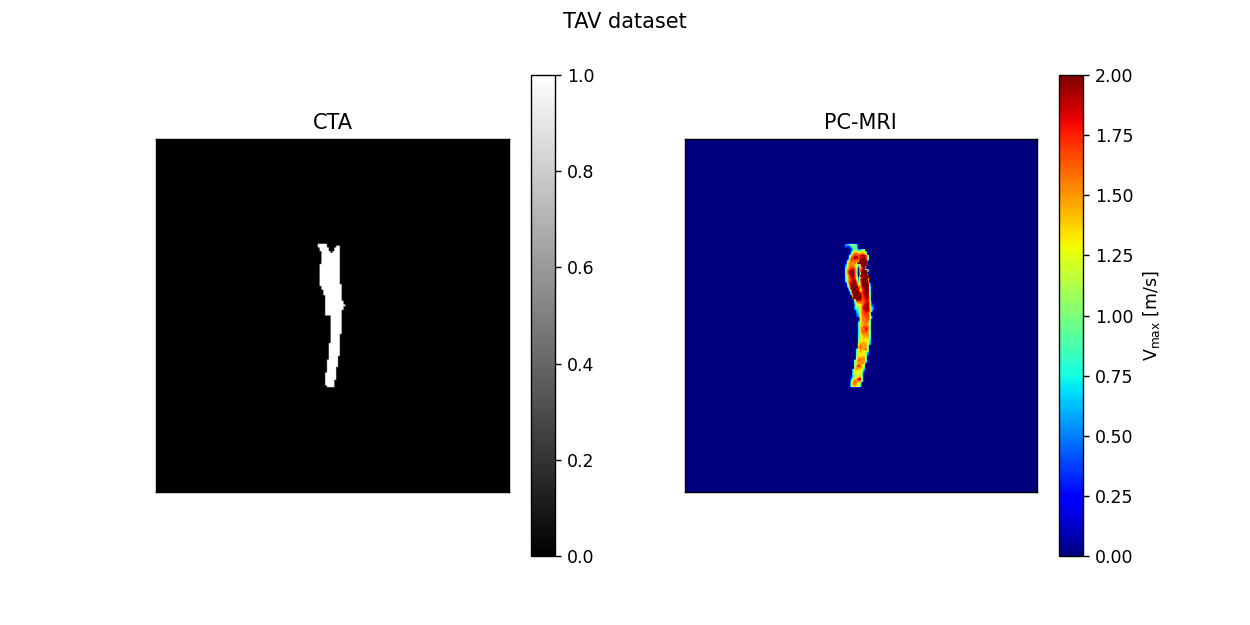

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation

# plot an anmiation that iterates over all subjects
%matplotlib notebook

key = list(data.keys())[0]
fig, axs = plt.subplots(1, 2, figsize=(10,5), facecolor='w')
fig.suptitle(f"{key.upper()} dataset")
im1 = axs[0].imshow(np.max(data[key]['anatomy'][0], axis=2), cmap='binary_r')
axs[0].set_title('CTA')
axs[0].set_xticks([])
axs[0].set_yticks([])
im2 = axs[1].imshow(np.max(data[key]['flow'][0], axis=2), cmap='jet', vmin=0, vmax=2)
axs[1].set_title('PC-MRI')
axs[1].set_xticks([])
axs[1].set_yticks([])
cb1 = fig.colorbar(im1, ax=axs[0])
cb2 = fig.colorbar(im2, ax=axs[1])
cb2.set_label('V$_{\mathrm{max}}$ [m/s]')
def update(ii):
    im1.set_data(np.max(data[key]['anatomy'][ii], axis=2))
    im2.set_data(np.max(data[key]['flow'][ii], axis=2))
ani = FuncAnimation(fig, update, frames=range(1, len(data[key]['anatomy'])), repeat=True)
plt.show()

## Create training and test datasets

In [4]:
import random

"""
This script creates a dictionary called "indices" that contains 3 keys: 'tav', 'bav', and 'ct2mri'.
Each of these keys points to another dictionary that contains two keys: 'train' and 'test'.

The script then iterates through the keys of the "indices" dictionary, and for each key:

it gets the number of subjects in the 'flow' of the data dictionary.
creates a list of integers from 0 to the number of subjects.
shuffles the list using a seed of 1337
splits the list into two parts, 60% of the list is for training and the rest for testing
assigns the splits to the 'train' and 'test' keys of the inner dictionary corresponding to the current key of the outer dictionary
prints the size of the training and test datasets for the current key
"""

indices= {'tav': {'train': [], 'test': []}, 
          'bav': {'train': [], 'test': []}, 
          'ct2mri': {'train': [], 'test': []}}

for key in indices.keys():

    number_subjects = len(data[key]['flow'])
    lst = [x for x in range(number_subjects)]
    random.Random(1337).shuffle(lst)
    tr_size = number_subjects*60//100
    te_size = number_subjects-tr_size
    print(f" {key.upper()} dataset: traini size: {tr_size}, test size: {te_size}")
    indices[key]['train'], indices[key]['test'] = lst[:tr_size], lst[tr_size:]


 TAV dataset: traini size: 302, test size: 202
 BAV dataset: traini size: 756, test size: 504
 CT2MRI dataset: traini size: 37, test size: 25


In [5]:
import tensorflow as tf

"""
This code is using the TensorFlow library to convert data into Tensorflow's binary file format
called TFRecord. It loops through indices_type and keys of indices, and for each key, 
it creates a filename for the TFRecord, creates a writer to write to the TFRecord, 
extracts anatomy and flow data from a data dictionary using the indices, converts the data to
numpy arrays with dtype of float32, gets the shape of the anatomy data, converts the numpy arrays
to bytes, creates a features dictionary, creates an example object, and writes the example to the
TFRecord. It then closes the writer.
"""

# loop through the type of indices
for indices_type in ['test','train']:
    # loop through the keys of indices
    for key in indices.keys():
        # create the filename for the tfrecord
        tfrecord_name = f"{key}_{indices_type}.tfrecords"
        # create a writer object to write to the tfrecord
        writer = tf.io.TFRecordWriter(tfrecord_name)
        # extract anatomy data from the data dictionary using the indices
        anatomy_data = [data[key]['anatomy'][ii] for ii in indices[key][indices_type]]
        # extract flow data from the data dictionary using the indices
        flow_data = [data[key]['flow'][ii] for ii in indices[key][indices_type]]
        # loop through anatomy and flow data
        for anatomy, flow in zip(anatomy_data, flow_data):
            # convert the data to numpy arrays with dtype of float32
            anatomy, flow = np.array(anatomy,dtype=np.float32), np.array(flow, dtype=np.float32)
            # get the shape of the anatomy data
            shape = np.shape(anatomy)
            # convert the numpy arrays to bytes
            anatomy = anatomy.tobytes()
            flow = flow.tobytes()
            # create the features dictionary
            features = {'anatomy': tf.train.Feature(bytes_list=tf.train.BytesList(value=[anatomy])),
                        'flow': tf.train.Feature(bytes_list=tf.train.BytesList(value=[flow])),
                        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[shape[0]])),
                        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[shape[1]])),
                        'depth':tf.train.Feature(int64_list=tf.train.Int64List(value=[shape[2]]))}
            # create the example object
            example = tf.train.Example(features = tf.train.Features(feature = features))
            # write the example to the tfrecord
            writer.write(example.SerializeToString())
        # close the writer
        writer.close()
